In [1]:
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from gutenberg.query import get_etexts
from gutenberg.query import get_metadata
import pandas as pd
import numpy as np
import re
import seaborn as sns
from bertopic import BERTopic # unsure of the installation worked correctly, since the color isn't adjusted
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

2022-08-22 03:20:54.998766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 03:20:54.998784: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Experimental Information Retrieval using Linked Data

##### This notebook aims to explore the feasability of a project. The idea is to find matching frases from famous novels upon prompst, whether silly or serious.

##### Examples for possible prompts: "part of an outdated law",  "first sentence after a tearsome romantic reunion", "what a giraffe could say to another giraffe", "well-intentioned advice for children", "line of a passive agressive message", "something that most people do at least twice a day"

##### The prompts obviously differ in complexity and the project should aim for the simpler ones first.

##### As an example novel, I picked "[Moby Dick](https://en.wikipedia.org/wiki/Moby-Dick)" by Herman Melville, which is in fact one of the more difficult novels for topic modeling, because there isn't so much variation regarding the scenes. But maybe the dialoges will then receive more importance. (Maybe we should actively give heigher weight to dialoges anyway ...)

In [2]:
text = strip_headers(load_etext(2701)).strip()
print(text[:46])

MOBY-DICK;

or, THE WHALE.

By Herman Melville


### Downloading one text

By command line input 

`python -m gutenberg.acquire.text 2701 moby-raw.txt` </br>
`python -m gutenberg.cleanup.strip_headers moby-raw.txt moby-clean.txt`

the novel is downloaded as a txt document (raw and clean version) within the current repo.

### Working with several documents:

From https://pypi.org/project/Gutenberg/:

Before you use one of the gutenberg.query functions you must populate the local metadata cache. This one-off process will take quite a while to complete (18 hours on my machine) but once it is done, any subsequent calls to get_etexts or get_metadata will be very fast. If you fail to populate the cache, the calls will raise an exception. </br>
</br>
To populate the cache:</br>
</br>
`from gutenberg.acquire import get_metadata_cache`</br>
`cache = get_metadata_cache()`</br>
`cache.populate()`</br>
</br>
Subsequently, queries such as `print(get_etexts('author', 'Melville, Hermann'))` can be used.</br>
</br>
Thoughts: maybe the cache should be situated on a GCP database instead?

#### Loading the Moby Dick text into a pandas dataframe

In [3]:
# Compiling a regex expression representing paragraphs
pattern = re.compile(r'(?:.+\n)+', re.MULTILINE) # regex expression should match any new paragraph, but needs to be double checked
with open('moby-clean.txt', 'r') as file:
    data = file.read()
pattern.findall(data)

# Writing the obtained paragraphs into a dataframe
data_df = pd.DataFrame(pattern.findall(data)).rename(columns={0: 'original paragraph'})
data_df["words per original paragraph"] = data_df["original paragraph"].apply(lambda x : len(x.split())) # it's not precise, but almost the number of words

data_df.iloc[237:247,:]

,original paragraph,words per original paragraph
237,CHAPTER 1. Loomings.\n,3
238,Call me Ishmael. Some years ago—never mind how...,198
239,There now is your insular city of the Manhatto...,68
240,Circumambulate the city of a dreamy Sabbath af...,113
241,"But look! here come more crowds, pacing straig...",101
242,Once more. Say you are in the country; in some...,119
243,But here is an artist. He desires to paint you...,355
244,"Now, when I say that I am in the habit of goin...",264
245,"No, when I go to sea, I go as a simple sailor,...",156
246,"What of it, if some old hunks of a sea-captain...",140


##### The first 236 paragraphs are just the title, author, the contents and some extracts. Some parts of these should be (not too tiedily) cleaned before saving the text in a db. Why not too tidiely? There might be some worth in it. Since this ipynb is experimental, I will skip this here.

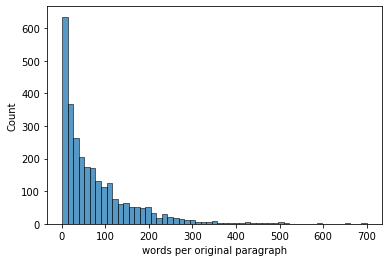

In [4]:
sns.histplot(data_df["words per original paragraph"]);

##### The paragraphs with less than 10 words will probably be wither capter titles or dialoges. In the former case we should try to get rid of them, in the latter however, we might think about joining the dialoges into larger sections (I would assume, that several consecutive shorter paragraphs might be dialogs).

##### Maybe we will also have to take care of paragraphs with more than 300 words.

In [5]:
example_parapgraph = data_df.iloc[892,0]
example_parapgraph

'“Why, thou monkey,” said a harpooneer to one of these lads, “we’ve been\ncruising now hard upon three years, and thou hast not raised a whale\nyet. Whales are scarce as hen’s teeth whenever thou art up here.”\nPerhaps they were; or perhaps there might have been shoals of them in\nthe far horizon; but lulled into such an opium-like listlessness of\nvacant, unconscious reverie is this absent-minded youth by the blending\ncadence of waves with thoughts, that at last he loses his identity;\ntakes the mystic ocean at his feet for the visible image of that deep,\nblue, bottomless soul, pervading mankind and nature; and every strange,\nhalf-seen, gliding, beautiful thing that eludes him; every\ndimly-discovered, uprising fin of some undiscernible form, seems to him\nthe embodiment of those elusive thoughts that only people the soul by\ncontinually flitting through it. In this enchanted mood, thy spirit\nebbs away to whence it came; becomes diffused through time and space;\nlike Cranmer’s spr

##### The text should be cleaned for new lines (/n), punctuation, from words like 'chapter' from pagination (numbers) and certainly many more, but I will skip this here.

### Topic Modeling with BERTopic

In [6]:
topic_model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7) # min_topic_size= 10 is default
paragraph_topics, probs = topic_model.fit_transform(data_df['original paragraph'])

Batches: 100%|██████████| 88/88 [00:17<00:00,  5.06it/s]
2022-08-22 03:21:14,960 - BERTopic - Transformed documents to Embeddings
2022-08-22 03:21:28,862 - BERTopic - Reduced dimensionality
2022-08-22 03:21:28,975 - BERTopic - Clustered reduced embeddings


##### There are sentence transformers and embedding models from Gensim and Spacy available, that later should be explored.

In [7]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1307,-1_the_and_of_to
1,0,103,0_the_boat_whale_boats
2,1,62,1_sperm_whale_is_the
3,2,53,2_chapter_whales_whale_of
4,3,52,3_sir_do_man_humbly
...,...,...,...
56,55,8,55_chapter_18_29_64
57,56,8,56_chapter_58_48_46
58,57,8,57_chapter_story_biographical_76
59,58,7,58_lbs_000_english_balls


In [8]:
topic_model.get_topic(0)

[('the', 0.017987476763218137),
 ('boat', 0.01590907759412246),
 ('whale', 0.014063890567452093),
 ('boats', 0.013165702741795925),
 ('to', 0.013007681005015839),
 ('of', 0.012886956288751644),
 ('in', 0.012683858173564733),
 ('and', 0.01267071373271991),
 ('his', 0.011994143921076032),
 ('by', 0.010924156644688066)]

##### We can see that stopwords make a huge impact on how these topics have been found. Maybe we should remove them first.

### Tokenization, Stopword Removal (also include Lemmatization?)

In [9]:
# For some reasons (virtenv?) I have to manually install Punkt from NLTK to make this work
import nltk
nltk.download('punkt')
# But since this is now sitting somewhere else, not in my virtenv, I'll have to transfer it there, somehow.

[nltk_data] Downloading package punkt to /home/stefanie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
data_df['modified paragraph'] = data_df['original paragraph'].apply(word_tokenize)
data_df.iloc[237:247,:]

,original paragraph,words per original paragraph,modified paragraph
237,CHAPTER 1. Loomings.\n,3,"[CHAPTER, 1, ., Loomings, .]"
238,Call me Ishmael. Some years ago—never mind how...,198,"[Call, me, Ishmael, ., Some, years, ago—never,..."
239,There now is your insular city of the Manhatto...,68,"[There, now, is, your, insular, city, of, the,..."
240,Circumambulate the city of a dreamy Sabbath af...,113,"[Circumambulate, the, city, of, a, dreamy, Sab..."
241,"But look! here come more crowds, pacing straig...",101,"[But, look, !, here, come, more, crowds, ,, pa..."
242,Once more. Say you are in the country; in some...,119,"[Once, more, ., Say, you, are, in, the, countr..."
243,But here is an artist. He desires to paint you...,355,"[But, here, is, an, artist, ., He, desires, to..."
244,"Now, when I say that I am in the habit of goin...",264,"[Now, ,, when, I, say, that, I, am, in, the, h..."
245,"No, when I go to sea, I go as a simple sailor,...",156,"[No, ,, when, I, go, to, sea, ,, I, go, as, a,..."
246,"What of it, if some old hunks of a sea-captain...",140,"[What, of, it, ,, if, some, old, hunks, of, a,..."


In [11]:
# Same reason as above; to do: have all dependencies be on the same place
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stefanie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('english'))

data_df['modified paragraph'] = data_df['modified paragraph'].apply(lambda x: [word for word in x if not word in stop_words])
data_df['words per modified paragraph'] = data_df['modified paragraph'].apply(lambda x : len(x)) # inprecise, because there's still punctuation in the sentences
data_df.iloc[237:247,:]

,original paragraph,words per original paragraph,modified paragraph,words per modified paragraph
237,CHAPTER 1. Loomings.\n,3,"[CHAPTER, 1, ., Loomings, .]",5
238,Call me Ishmael. Some years ago—never mind how...,198,"[Call, Ishmael, ., Some, years, ago—never, min...",135
239,There now is your insular city of the Manhatto...,68,"[There, insular, city, Manhattoes, ,, belted, ...",44
240,Circumambulate the city of a dreamy Sabbath af...,113,"[Circumambulate, city, dreamy, Sabbath, aftern...",87
241,"But look! here come more crowds, pacing straig...",101,"[But, look, !, come, crowds, ,, pacing, straig...",72
242,Once more. Say you are in the country; in some...,119,"[Once, ., Say, country, ;, high, land, lakes, ...",73
243,But here is an artist. He desires to paint you...,355,"[But, artist, ., He, desires, paint, dreamiest...",235
244,"Now, when I say that I am in the habit of goin...",264,"[Now, ,, I, say, I, habit, going, sea, wheneve...",183
245,"No, when I go to sea, I go as a simple sailor,...",156,"[No, ,, I, go, sea, ,, I, go, simple, sailor, ...",107
246,"What of it, if some old hunks of a sea-captain...",140,"[What, ,, old, hunks, sea-captain, orders, get...",90


##### After recalculating the words per paragraph, we can see that those have changed and the stopwords have been removed. Due to a different way of counting words (punctuation was at first excluded, now it's included) the results aren't fully comparable.

### Topic Modeling with BERTopic with removed stopwords

In [13]:
topic_model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 3) # min_topic_size= 10 is default
paragraph_topics, probs = topic_model.fit_transform(data_df['modified paragraph'].apply(lambda x: ' '.join(x))) # the pd.series must be a series of strings, not list of strings

Batches: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s]
2022-08-22 03:21:56,435 - BERTopic - Transformed documents to Embeddings
2022-08-22 03:22:05,543 - BERTopic - Reduced dimensionality
2022-08-22 03:22:05,727 - BERTopic - Clustered reduced embeddings


In [14]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1002,-1_whale_one_like_but
1,0,39,0_captain_shock_child_let
2,1,34,1_sir_humbly_nothing_pitch
3,2,33,2_cook_supper_clam_hussey
4,3,30,3_sailor_dance_row_ah
...,...,...,...
197,196,3,196_yellow_boys_beam_archy
198,197,3,197_voice_admonishing_shrill_reporting
199,198,3,198_awed_glance_appeared_never
200,199,3,199_job_cobbling_coffin_jobs


In [15]:
topic_model.get_topic(0)

[('captain', 0.06299847337059894),
 ('shock', 0.026412689090352718),
 ('child', 0.02514244761756917),
 ('let', 0.017727841950033393),
 ('said', 0.016859083163282843),
 ('want', 0.01678144104549517),
 ('roared', 0.01644828548394441),
 ('bunger', 0.01644828548394441),
 ('lionel', 0.015118660547736352),
 ('sir', 0.01489309362353088)]

##### The topics seem to be clearer defined and we notice that since we reduced the words that would play a role in topic modeling, we need to adjust the min_topic_size in order to reach some density within our clusters. </br>

##### We can see that words are taken into account separetely, even though "Sperm Whale" would be a named entity. We'll need to adress this.

##### It's a problem though, that we still have many paragraphs, that don't belong to any topic. These might not be outliers, but simply paragraphs with < min_topic_size topics.

### Some Visualisation

In [16]:
topic_model.visualize_barchart(top_n_topics=8)

##### Reoccuring topic words such as "ships" and "ship" might show that lemmatization needs to be implemented before fitting the BERTopic model. Also, named enities should be recognized, because otherwise "sperm" and "whale" will be considered two different words, instead of "sperm whale". The names of literary characters should also be removed before topic modeling, since they only distract the model from seeing the more general patters.

In [17]:
topic_model.visualize_topics()

##### We can see that with the chosen min_topic_size= 3 we seem to get many overlapping topics (or this is just due to dimensionality reduction). Though when we would increase min_topic_size, we would have even more paragraphs without a topic. I think regarding the goal of finding our topics to match with a prompt, it's good to have as many topics as possible, even if there's only a hand full of different paragraphs per topic. Overfitting is totally fine here.

In [18]:
topic_model.visualize_hierarchy(top_n_topics=30)

### Similarity to prompts

##### BERTopic also allows us to find clusters, that are semantically similar to queries:

In [19]:
similar_topics, similarity = topic_model.find_topics("part of an outdated law", top_n = 3)
print(similar_topics, similarity)
topic_model.get_topic(similar_topics[0])

[90, 141, 132] [0.42572209120991295, 0.4213755998316889, 0.3386571840246249]


[('whaling', 0.07008821738338963),
 ('respectable', 0.05467785006383406),
 ('advocate', 0.05171432732413198),
 ('laws', 0.04596793645959363),
 ('facts', 0.04596793645959363),
 ('society', 0.04339865100167364),
 ('deemed', 0.03890708211746501),
 ('dignity', 0.03531442408684792),
 ('law', 0.03482596912235667),
 ('advance', 0.03436101070166839)]

##### As we can see, the semantic similarity approach returns predictable results: It returns clusters, that have simiplar words as the query. However, this is not what we want.

##### Let's still have a look into what kind of matches it would find us:

In [47]:
# Returning a list of three paragraphs, that match the query "part of an outdated law"
potentially_matching_paragraphs = topic_model.get_representative_docs(similar_topics[0])
potentially_matching_paragraphs

['Good ; confess somehow whaling respectable .',
 'Grant , since cite ; , say , real dignity whaling .',
 'In behalf dignity whaling , I would fain advance naught substantiated facts . But embattling facts , advocate wholly suppress unreasonable surmise , might tell eloquently upon cause—such advocate , would blameworthy ?']

##### Those are the modified paragraphs the model was fitted on. Let's match them to the plain text paragraphs.

In [48]:
indexes_of_matches = []
for para in potentially_matching_paragraphs: 
    one_match_in_df = data_df[data_df['modified paragraph'].apply(lambda x: ' '.join(x)) == para].index[0]
    indexes_of_matches.append(one_match_in_df)
indexes_of_matches

for index in indexes_of_matches:
    print(data_df.iloc[index, 0])

Good again; but then all confess that somehow whaling is not
respectable.

Grant it, since you cite it; but, say what you will, there is no real
dignity in whaling.

In behalf of the dignity of whaling, I would fain advance naught but
substantiated facts. But after embattling his facts, an advocate who
should wholly suppress a not unreasonable surmise, which might tell
eloquently upon his cause—such an advocate, would he not be
blameworthy?



##### Obviously, those paragraphs don't match the query "part of an outdated law" . But they are somehow connected.

### Experiments with Linkes Open Data

##### Now I want to try, if deflecting the original query before passing it, will return better results.

##### In order to do so, I will use [Linked Open Data](https://en.wikipedia.org/wiki/Linked_data#Linked_open_data).